<a href="https://colab.research.google.com/github/UTakeuchi/PDsimulator/blob/main/main_case1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Q学習エージェント

In [2]:
def greedy_probs(Q, state, epsilon=0, action_size=2):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)
    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}  #{0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs

In [3]:
class Agent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 2
        self.income = 0 #所得
        #self.rep = 'g' #評判(good or bad)    

        random_actions = {0: 0.5, 1: 0.5}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
    
    def get_action(self, state):
        action_probs = self.b[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def inc_update(self, reward):
        self.income += reward #income update

    def update(self, state, action, reward, next_state):
        next_qs = [self.Q[next_state, a] for a in range(self.action_size)]
        next_q_max = max(next_qs)
        
        target = reward + self.gamma * next_q_max
        self.Q[state, action] += self.alpha * (target - self.Q[state, action])

        self.pi[state] = greedy_probs(self.Q, state, epsilon=0)
        self.b[state] = greedy_probs(self.Q, state, self.epsilon)

# Prisoner's dillema game

In [4]:
class PDGame:
    def __init__(self):
        self.action_space = [0, 1]
        self.action_meaning = {
            0: "Defect",
            1: "Cooperate",
        }
        self.b = 5 #benefit
        self.c = 1 #cost
    
    def matching(self, agents):
        pairs = len(agents) // 2
        return np.random.choice(agents, size=(pairs, 2), replace=False)
        
    def reward(self, a1, a2):
        u1 = {(1, 1):self.b - self.c, (1, 0):-self.c, (0, 1):self.b, (0, 0):0}
        u2 = {(1, 1):self.b - self.c, (1, 0):self.b, (0, 1):-self.c, (0, 0):0}
        return u1[(a1,a2)], u2[(a1,a2)]

## 平均値を返す関数

In [5]:
def avg(agents):
    ret = 0
    for agent in agents:
        ret += agent.income
    return ret / len(agents)

# シミュレーションの実行

----------agent1's policy-----------
state:(0, 0, 0.0), policy:{0: 1.0, 1: 0.0}
state:(-1, 18, 8.0), policy:{0: 1.0, 1: 0.0}
state:(-1, 7, 8.0), policy:{0: 0.0, 1: 1.0}
state:(3, 18, 10.666666666666666), policy:{0: 1.0, 1: 0.0}
state:(3, 22, 13.333333333333334), policy:{0: 1.0, 1: 0.0}
state:(3, 15, 13.333333333333334), policy:{0: 1.0, 1: 0.0}
state:(2, 26, 17.333333333333332), policy:{0: 1.0, 1: 0.0}
state:(7, 24, 20.0), policy:{0: 1.0, 1: 0.0}
state:(12, 27, 24.0), policy:{0: 1.0, 1: 0.0}
state:(11, 32, 25.333333333333332), policy:{0: 1.0, 1: 0.0}
state:(11, 33, 25.333333333333332), policy:{0: 1.0, 1: 0.0}
state:(10, 38, 26.666666666666668), policy:{0: 1.0, 1: 0.0}
state:(15, 32, 28.0), policy:{0: 1.0, 1: 0.0}
state:(15, 37, 28.0), policy:{0: 1.0, 1: 0.0}
state:(20, 38, 34.666666666666664), policy:{0: 1.0, 1: 0.0}
state:(19, 45, 37.333333333333336), policy:{0: 1.0, 1: 0.0}
state:(18, 48, 38.666666666666664), policy:{0: 0.0, 1: 1.0}
state:(22, 50, 41.333333333333336), policy:{0: 0.0, 

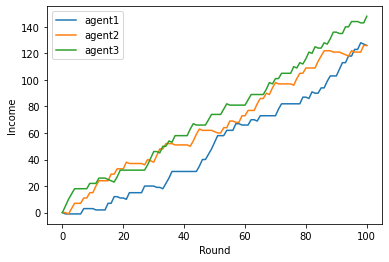

In [8]:
env = PDGame()
n = 3 # agentの人数 n
agents = []
income_history = []
for i in range(n):
    agents.append(Agent())
    income_history.append([0])

rounds = 100
for round in range(rounds):
    players = env.matching(agents)
    #average = avg(agents) 平均値の情報が１ラウンドごとに変わる場合
    for pair in players:
        player1, player2 = pair
        state1 = (player1.income, player2.income, avg(agents)) #stateは（自分の所得, 相手の所得, 全体の平均値）の順にする
        state2 = (player2.income, player1.income, avg(agents))
    
        a1 = player1.get_action(state1)
        a2 = player2.get_action(state2) 
        r1, r2 = env.reward(a1, a2)

        nr1, nr2 = player1.inc_update(r1), player2.inc_update(r2)
        next_state1 = (nr1, nr2, avg(agents))
        next_state2 = (nr2, nr1, avg(agents))
        player1.update(state1, a1, r1, next_state1)
        player2.update(state2, a2, r2, next_state2) #player2目線に変換

    for i in range(n):
        income_history[i].append(agents[i].income)

for i in range(n):
    print("----------agent{}'s policy-----------".format(i+1))
    for key, value in agents[i].pi.items():
        print('state:{}, policy:{}'.format(key, value))
    print('policy number = ' + str(len(agents[i].pi)))

def plot_total_income(history):
    plt.xlabel('Round')
    plt.ylabel('Income')
    for i in range(n):
        plt.plot(range(len(history[i])), history[i], label='agent{}'.format(i+1))
    plt.legend()
    plt.show()

plot_total_income(income_history)